<h1 style="text-align: center;">Simulación y aplicaciones en ciencias sociales y experimentales
</h3>
<h3 style="text-align: center;"> Tema 3. Modelos aleatorios </h3>
<h3 style="text-align: center;"> Modelo de Colas (ejercicios propuestos) </h3>

### Ejercicio 

Se propone un ejercicio teórico-práctico. Consiste en idear un modelo para un sistema real aleatorio markoviano, con planteamiento lipre. Se valorará positivamente que el ajuste o estimación de los parámetros o variables aleatorias iniciales a partir de muestreos o toma de datos reales. El objetivo del modelo es ayudar a través de las simulaciones a la toma de decisiones óptimas de gestión/utilización del sistema

Se dan dos ejemplos a modo de sugerencias, pero puede ser cualquier otro proceso markoviano similar a los estudiados. 

- Juego de azar sin memoria, en el que el conjunto de estados es finito (ganar, perder, empatar, etc.) y las probabilidades son fijas. A través del modelo se simularía el estado a largo plazo del jugador, así como la estrategia que optimizara un objetivo determinado.  

- Un comercio que se pide en barra (ferretería, cafetería, etc), en la cual se dispone de una (o varias) personas antendiendo, con un tiempo de atención y servicio medio determinado. Cada servicio supone un ingreso económico y la llegada de clientes se produce cada cierto tiempo y se ponen en cola. Si la cola excede de un número de individuos, el cliente abandona el local. Se podría estudiar el ingreso y pérdida diaria por abandono del cliente, así como la conveniencia o no de contratar a otro empleado si su salario es $w$ por día. 

### Gimnasio FitnessPark - Las Ramblas

**Planteamiento del Modelo**: Se modela la gestión de un gimnasio como un sistema estocástico markoviano. En este modelo, el conjunto de estados está definido por la ocupación de los diferentes tipos de máquinas disponibles y el tamaño de la cola de usuarios que esperan para acceder al equipo. Las transiciones entre estados dependen de tasas dinámicas de llegada y salida de usuarios, y del comportamiento de los mismos ante el tiempo de espera.

**Variables del Modelo**:
- N_equipos: Número de máquinas disponibles por tipo, representando los recursos limitados del gimnasio.
- mu: Tasa de uso medio de cada tipo de máquina, que refleja el tiempo promedio que un usuario ocupa el equipo.
- umbral_cola: Límite de la cola que los usuarios consideran aceptable antes de abandonar el gimnasio.
- max_intentos: Número máximo de intentos que un usuario realizará para encontrar una máquina disponible antes de abandonar definitivamente el gimnasio.
- horarios: Periodos del día con distintas tasas de llegada de usuarios (lambda_), que reflejan variaciones en la demanda a lo largo de la jornada.

**Funcionamiento del Modelo**:
- Estados: Cada estado describe la ocupación actual de las máquinas y el tamaño de la cola.
- Matriz de Transición Dinámica: En lugar de predefinir todas las probabilidades de transición entre estados, el modelo calcula dinámicamente las transiciones posibles desde el estado actual, reduciendo así el consumo de memoria, ya que solo se almacenan las probabilidades relevantes para el estado actual y no la matriz completa.

**Simulación**:
Se inicializa el sistema en un estado libre (sin usuarios), en cada paso de tiempo, se evalúan las posibles transiciones (llegadas, salidas, y abandonos) y se selecciona la próxima transición según las probabilidades calculadas. 
Resultados por horas del día:
- Ocupación promedio por tipo de máquina.
- Número y tasa de cambio de máquina (usuarios que dejan la cola para intentar otras máquinas).
- Número y tasa de abandono del gimnasio (usuarios que se van del gimnasio por alta ocupación en la mayoría de máquinas).


De tal manera que el modelo permite identificar las máquinas con mayor y menor demanda, la proporción de usuarios que abandonan el gimnasio o cambian de máquina ya que la que iban a utilizar está demasiado saturada, podría añadirse algún aspecto para incluso evaluar el nivel de satisfacción del cliente.
Con lo cual, a partir de diferentes simulaciones el gimnasio puede ver escenarios con más máquinas o cambios en las tasas de llegada/salida, se puede evaluar la conveniencia de invertir en nuevos equipos, o eliminar algunos que no se les de tanta utilidad, ayudando así a la toma de decisiones para optimizar el número de máquinas a proveer, cambios en los horarios, y más medidas en caso de que se añadieran variables como el número de entrenadores personales, etc.

En este modelo pensamos en la posibilidad de añadir en el horario también el día de la semana, pero en el caso de las máquinas de un gimnasio, ajustar las tasas por días de la semana podría no ser tan útil para la gestión operativa ya que no es factible quitar o añadir máquinas según el día debido a que se tratan de recursos fijos y su disponibilidad no cambia.

### Parámetros del modelo
Los parametros se pueden ajustar con los datos muestreados de cualquier gimnasio, en este caso, basándonos en nuestra experiencia de haber ido a un gimnasio durante alrededor de un año, creemos que los valores establecidos son los valores más típicos que se dan durante esos horarios.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del sistema
N_equipos = {"poleas": 4, "prensa": 5, "banco": 8, "cintas":8, "multipower": 2}  # Número de equipos por tipo
mu = {"poleas": 15, "prensa": 10, "banco": 10, "cintas": 30, "multipower": 10}       # Tasa de uso por tipo (minutos)
T_total = 7560                                                       # Duración de la simulación (minutos)
umbral_cola = 2                                                      # Umbral para considerar abandono
max_intentos = 5                                                     # Máximo de intentos antes de abandonar el gimnasio

# Parámetros de franjas horarias ajustadas (de 6:00 a 24:00)
# Usuarios por hora por tipo de equipo
horarios = {
    "mañana": {"inicio": 6, "fin": 10, "lambda": {"poleas": 15, "prensa": 10, "banco": 12, "cintas": 25, "multipower": 8}},
    "mediodía": {"inicio": 10, "fin": 16, "lambda": {"poleas": 16, "prensa": 10, "banco": 15, "cintas": 18, "multipower": 4}},
    "tarde": {"inicio": 16, "fin": 20, "lambda": {"poleas": 40, "prensa": 25, "banco": 28, "cintas": 25, "multipower": 20}},
    "noche": {"inicio": 20, "fin": 24, "lambda": {"poleas": 25, "prensa": 18, "banco": 15, "cintas": 20, "multipower": 12}},
}

maquina_indice = {"poleas": 0, "prensa": 1, "banco": 2, "cintas": 3, "multipower": 4}
indice_maquina = {v: k for k, v in maquina_indice.items()}

In [26]:
# Generar todos los estados posibles
def generar_estados(N_equipos):
    """Genera todos los estados posibles como combinaciones de ocupación."""
    estados = []
    for b in range(N_equipos["poleas"] + 1):
        for c in range(N_equipos["prensa"] + 1):
            for p in range(N_equipos["banco"] + 1):
                for e in range(N_equipos["cintas"] + 1):
                    for mp in range(N_equipos["multipower"] + 1):
                        for q in range(10):  # Hasta 10 en cola (configurable)
                            estados.append((b, c, p, e, mp, q))
    return estados



# Función para asignar franja horaria según la hora
def franja_horaria(hora_actual):
    """Devuelve la franja horaria correspondiente a la hora actual."""
    for franja, datos in horarios.items():
        if datos["inicio"] <= hora_actual < datos["fin"]:
            return franja
    return None  # Hora fuera del horario del gimnasio



# Ajustar hora para que esté dentro del horario de apertura
def get_hora(tiempo_actual):
    """Ajusta el tiempo actual para ignorar las horas fuera del horario del gimnasio."""
    hora_actual = tiempo_actual % 24
    while hora_actual < 6 or hora_actual >= 24:  # Si está fuera del horario [6, 24)
        tiempo_actual += 1  # Avanzamos al siguiente minuto
        hora_actual = tiempo_actual % 24
    return tiempo_actual



# Obtener tasas dinámicas según la hora actual
def get_lambda(hora_actual):
    """Devuelve las tasas de llegada (lambda) según la hora actual."""
    for franja, datos in horarios.items():
        if datos["inicio"] <= hora_actual < datos["fin"]:
            return datos["lambda"]
    return {"poleas": 1, "prensa": 1, "banco": 1, "elipticas": 1}  # Default si algo falla


#Función para calcular probabilidad de abandono dinámica
def prob_cambio_maquina(q, umbral_cola):
    """Devuelve la probabilidad de abandono en función del tamaño de la cola."""
    if q <= umbral_cola:
        return 0  # Sin abandono por debajo del umbral
    else:
        return min(0.5 * (q - umbral_cola + 1), 1.0)  # Crecimiento más rápido


# Generar dinámicamente las probabilidades de transición
def transicion_dinamica(estado_actual, estados, N_equipos, lambda_, mu, umbral_cola):
    """Calcula las probabilidades de transición dinámicamente desde un estado."""
    transiciones = []
    probabilidades = []

    b, c, p, e, mp, q = estado_actual

    for estado_siguiente in estados:
        b_, c_, p_, e_, mp_, q_ = estado_siguiente
        prob = 0

        # Llegada de usuario
        for tipo, max_eq in N_equipos.items():
            indice = maquina_indice[tipo]
            if estado_actual[indice] < max_eq:  # Máquina disponible
                if estado_siguiente[indice] == estado_actual[indice] + 1 and q_ == q:
                    prob += lambda_[tipo] / sum(lambda_.values())
            else:  # Máquinas ocupadas, usuario entra en cola
                if estado_siguiente[-1] == q + 1:
                    prob += lambda_[tipo] / sum(lambda_.values())

        # Salida de usuario
        for tipo in N_equipos:
            indice = maquina_indice[tipo]
            if estado_actual[indice] > 0:  # Máquina ocupada
                if estado_siguiente[indice] == estado_actual[indice] - 1 and q_ == q:
                    prob += mu[tipo] / sum(mu.values())
            elif q > 0:  # Reducir cola y asignar máquina
                if estado_siguiente[-1] == q - 1 and estado_siguiente[indice] == estado_actual[indice] + 1:
                    prob += mu[tipo] / sum(mu.values())

        # Abandono dinámico
        if q > 0 and q_ == q - 1:
            prob += prob_cambio_maquina(q, umbral_cola)

        # Abandono global
        if all(estado_actual[indice] >= N_equipos[tipo] for tipo, indice in maquina_indice.items()) and q >= umbral_cola:
            prob += 0.9  # Alta probabilidad de abandonar el gimnasio

        if prob > 0:
            transiciones.append(estado_siguiente)
            probabilidades.append(prob)

    # Normalizar las probabilidades
    total = sum(probabilidades)
    probabilidades = [p / total for p in probabilidades]

    return transiciones, probabilidades



# Simulación del sistema con transiciones dinámicas
def simulacion_markov(estados, N_equipos, T_total, mu, umbral_cola):
    """Simula el sistema con transiciones generadas dinámicamente."""
    estado_actual = estados[0]  # Comenzamos con todo libre (primer estado)
    all_estados = []
    all_franjas = []
    tiempo_actual = 0

    # Inicializar contadores por franja horaria
    contadores_franja = {franja: {"cambio_maquina": 0, "abandono": 0} for franja in horarios.keys()}

    while tiempo_actual < T_total:
        hora_actual = tiempo_actual % 24
        lambda_ = get_lambda(hora_actual)
        franja_actual = next((f for f, v in horarios.items() if v["inicio"] <= hora_actual < v["fin"]), None)

        # Ignorar si está fuera del horario
        if franja_actual is None:
            tiempo_actual += 1
            continue

        all_franjas.append(franja_actual)

        # Generar transiciones dinámicas
        transiciones, probabilidades = transicion_dinamica(estado_actual, estados, N_equipos, lambda_, mu, umbral_cola)

        # Elegir transición
        estado_siguiente = transiciones[np.random.choice(len(transiciones), p=probabilidades)]

        # Detectar cambio de máquina
        if estado_actual[-1] > estado_siguiente[-1]:  # Cola disminuyó
            contadores_franja[franja_actual]["cambio_maquina"] += 1

        # Detectar abandono global
        if sum(estado_actual[indice] >= N_equipos[tipo] for tipo, indice in maquina_indice.items()) >= len(maquina_indice) - 1 and estado_actual[-1] >= umbral_cola:
            contadores_franja[franja_actual]["abandono"] += 1

        estado_actual = estado_siguiente
        all_estados.append(estado_actual)

        tiempo_actual += 1

    return all_estados, all_franjas, contadores_franja




def analizar_franjas(historial_estados, historial_franjas, contadores_franja, N_equipos):
    """Calcula ocupación por máquina y tasas por franja horaria."""
    resultados_franja = {}

    # Inicializar estructuras de datos
    for franja in horarios.keys():
        resultados_franja[franja] = {
            "ocupacion": {maquina: 0 for maquina in N_equipos.keys()},
            "contador": 0,
            "cambio_maquina": contadores_franja[franja]["cambio_maquina"],
            "abandono": contadores_franja[franja]["abandono"],
        }

    # Recorremos los estados y las franjas
    for i, estado in enumerate(historial_estados):
        franja_actual = historial_franjas[i]
        if franja_actual is not None:
            resultados_franja[franja_actual]["contador"] += 1

            # Acumular ocupación por máquina
            for maquina, indice in maquina_indice.items():
                resultados_franja[franja_actual]["ocupacion"][maquina] += estado[indice]

    # Calcular promedios y tasas por franja
    for franja, datos in resultados_franja.items():
        for maquina in N_equipos.keys():
            if datos["contador"] > 0:
                datos["ocupacion"][maquina] /= datos["contador"]
        datos["tasa_cambio_maquina"] = datos["cambio_maquina"] / max(1, datos["contador"])
        datos["tasa_abandono"] = datos["abandono"] / max(1, datos["contador"])

    return resultados_franja


In [27]:
# Configurar y ejecutar simulación
estados = generar_estados(N_equipos)
all_estados, all_franjas, contadores_franja = simulacion_markov(
    estados, N_equipos, T_total, mu, umbral_cola
)

# Analizar resultados
resultados_franja = analizar_franjas(all_estados, all_franjas, contadores_franja, N_equipos)

# Mostrar resultados por franjas horarias
print("\nResultados por franja horaria:")
for franja, datos in resultados_franja.items():
    print(f"\nFranja horaria: {franja}")
    print("  Ocupación promedio por máquina:")
    for maquina, ocupacion in datos["ocupacion"].items():
        print(f"    {maquina.capitalize()}: {ocupacion:.2f}")
    print(f"  Cambios de máquina: {datos['cambio_maquina']}")
    print(f"  Abandonos: {datos['abandono']}")
    print(f"  Tasa de cambios de máquina: {datos['tasa_cambio_maquina']:.2f}")
    print(f"  Tasa de abandono: {datos['tasa_abandono']:.2f}")

# Mostrar resultados globales
total_cambios_maquina = sum(c["cambio_maquina"] for c in contadores_franja.values())
total_abandonos = sum(c["abandono"] for c in contadores_franja.values())
print("\nResultados globales:")
print(f"  Total cambios de máquina: {total_cambios_maquina}")
print(f"  Total abandonos: {total_abandonos}")



Resultados por franja horaria:

Franja horaria: mañana
  Ocupación promedio por máquina:
    Poleas: 1.97
    Prensa: 2.49
    Banco: 4.02
    Cintas: 3.99
    Multipower: 1.00
  Cambios de máquina: 288
  Abandonos: 2
  Tasa de cambios de máquina: 0.23
  Tasa de abandono: 0.00

Franja horaria: mediodía
  Ocupación promedio por máquina:
    Poleas: 1.97
    Prensa: 2.45
    Banco: 4.08
    Cintas: 3.89
    Multipower: 0.95
  Cambios de máquina: 432
  Abandonos: 5
  Tasa de cambios de máquina: 0.23
  Tasa de abandono: 0.00

Franja horaria: tarde
  Ocupación promedio por máquina:
    Poleas: 2.00
    Prensa: 2.54
    Banco: 4.05
    Cintas: 3.90
    Multipower: 0.99
  Cambios de máquina: 270
  Abandonos: 3
  Tasa de cambios de máquina: 0.21
  Tasa de abandono: 0.00

Franja horaria: noche
  Ocupación promedio por máquina:
    Poleas: 2.00
    Prensa: 2.48
    Banco: 3.98
    Cintas: 3.94
    Multipower: 0.99
  Cambios de máquina: 292
  Abandonos: 3
  Tasa de cambios de máquina: 0.23
  Tas

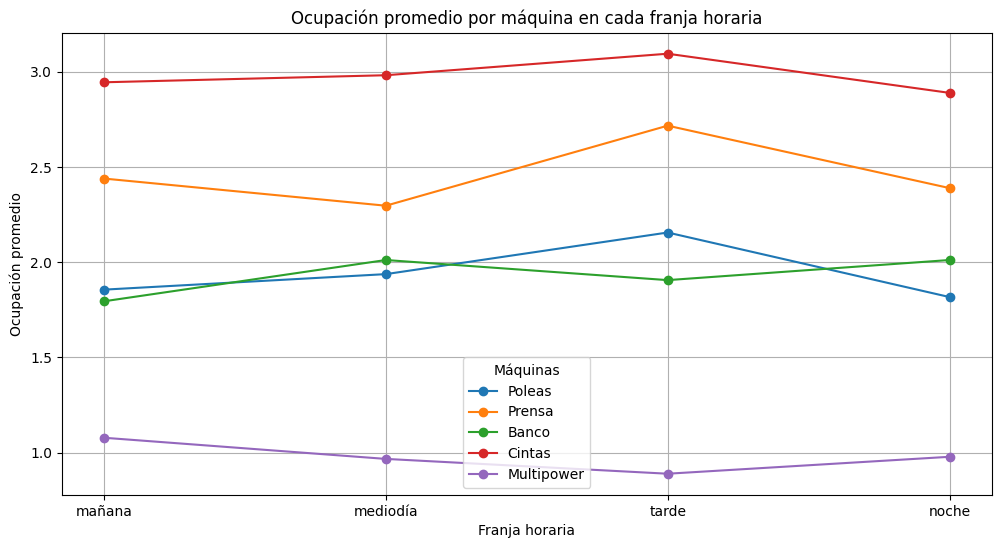

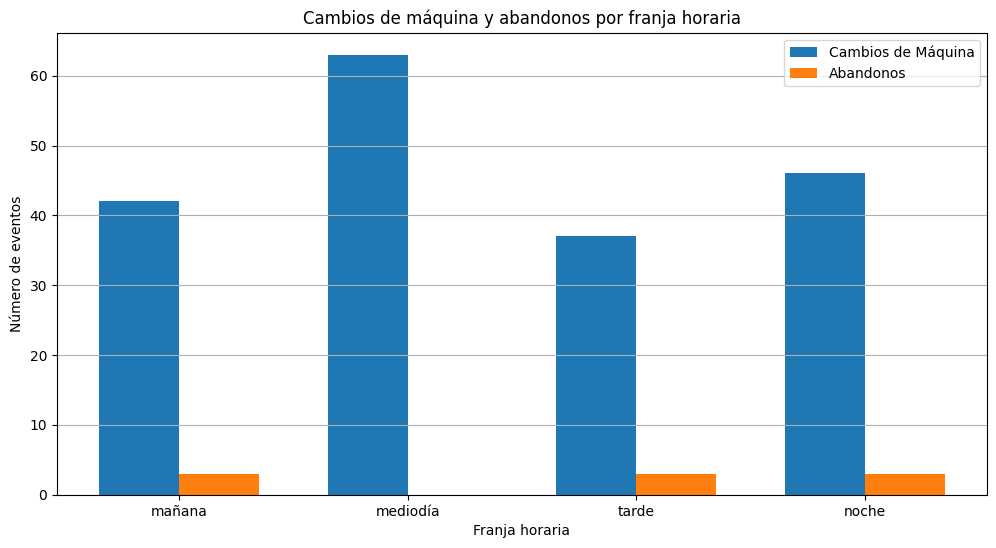

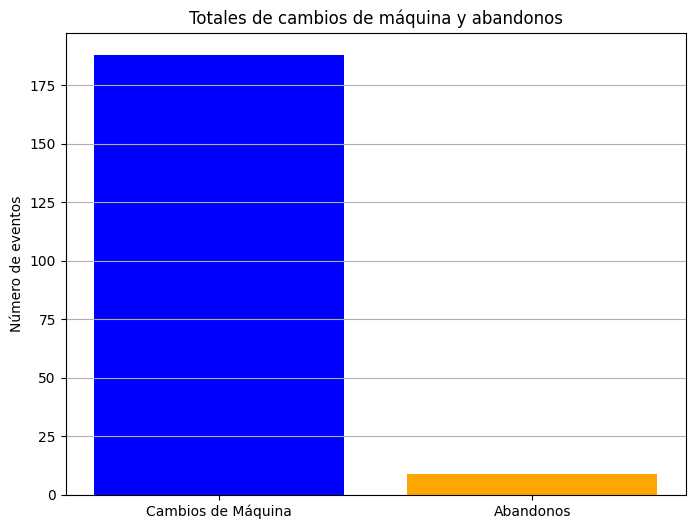

In [14]:
# Crear gráficas
def generar_graficas(resultados_por_franja, contadores_franja):
    # Datos para las gráficas
    franjas = list(resultados_por_franja.keys())
    maquinas = list(next(iter(resultados_por_franja.values()))["ocupacion"].keys())

    # --- Gráfica 1: Ocupación promedio por máquina en cada franja horaria ---
    plt.figure(figsize=(12, 6))
    for maquina in maquinas:
        ocupacion = [resultados_por_franja[franja]["ocupacion"][maquina] for franja in franjas]
        plt.plot(franjas, ocupacion, marker="o", label=maquina.capitalize())
    plt.title("Ocupación promedio por máquina en cada franja horaria")
    plt.xlabel("Franja horaria")
    plt.ylabel("Ocupación promedio")
    plt.legend(title="Máquinas")
    plt.grid()
    plt.show()

    # --- Gráfica 2: Cambios de máquina y abandonos por franja horaria ---
    cambios_maquina_franja = [contadores_franja[franja]["cambio_maquina"] for franja in franjas]
    abandonos_franja = [contadores_franja[franja]["abandono"] for franja in franjas]

    x = np.arange(len(franjas))  # Posiciones para las barras
    width = 0.35  # Ancho de las barras

    plt.figure(figsize=(12, 6))
    plt.bar(x - width / 2, cambios_maquina_franja, width, label="Cambios de Máquina")
    plt.bar(x + width / 2, abandonos_franja, width, label="Abandonos")
    plt.title("Cambios de máquina y abandonos por franja horaria")
    plt.xlabel("Franja horaria")
    plt.ylabel("Número de eventos")
    plt.xticks(x, franjas)
    plt.legend()
    plt.grid(axis="y")
    plt.show()

    # --- Gráfica 3: Totales de cambios de máquina y abandonos ---
    total_cambios_maquina = sum(cambios_maquina_franja)
    total_abandonos = sum(abandonos_franja)

    labels = ["Cambios de Máquina", "Abandonos"]
    valores = [total_cambios_maquina, total_abandonos]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, valores, color=["blue", "orange"])
    plt.title("Totales de cambios de máquina y abandonos")
    plt.ylabel("Número de eventos")
    plt.grid(axis="y")
    plt.show()


# Generar gráficas con los resultados de la simulación
generar_graficas(resultados_franja, contadores_franja)
